In [1]:
import os
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import openalea.phenomenal.object.voxelSegmentation as phm_seg

from openalea.maizetrack.trackedPlant import TrackedPlant
from openalea.maizetrack.display import PALETTE
from openalea.maizetrack.phenomenal_coupling import phm_to_phenotrack_input

from datadir import datadir

In [2]:
def plot3d(polylines, ranks):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')
    plt.axis('off')
    for pl, rank in zip(polylines, ranks):
        color = PALETTE[int(rank - 1)]/255. if rank > 0 else np.array([80, 80, 80])/255.
        linestyle = '-' if rank > 0 else '--'
        ax.plot(pl[:, 0], pl[:, 1], zs=pl[:, 2], color=color, linewidth=0.7, linestyle=linestyle)

# 1 - Data Preparation

# Load a time-series of segmented plant (from Phenomenal)

In [3]:
fd = datadir + '/3d_time_series'
phm_segs, timestamps = [], []
for filename in os.listdir(fd):
    timestamps.append(int(filename.split('.gz')[0]))
    phm_segs.append(phm_seg.VoxelSegmentation.read_from_json_gz(os.path.join(fd, filename)))

# Conversion to a generic format

In [4]:
phenotrack_segs, checks_stem = phm_to_phenotrack_input(phm_segs, timestamps)

print(f'{len(phm_segs) - len(phenotrack_segs)} time-step was removed due to an abnormal stem shape')

1 time-step was removed due to an abnormal stem shape


<IPython.core.display.Javascript object>


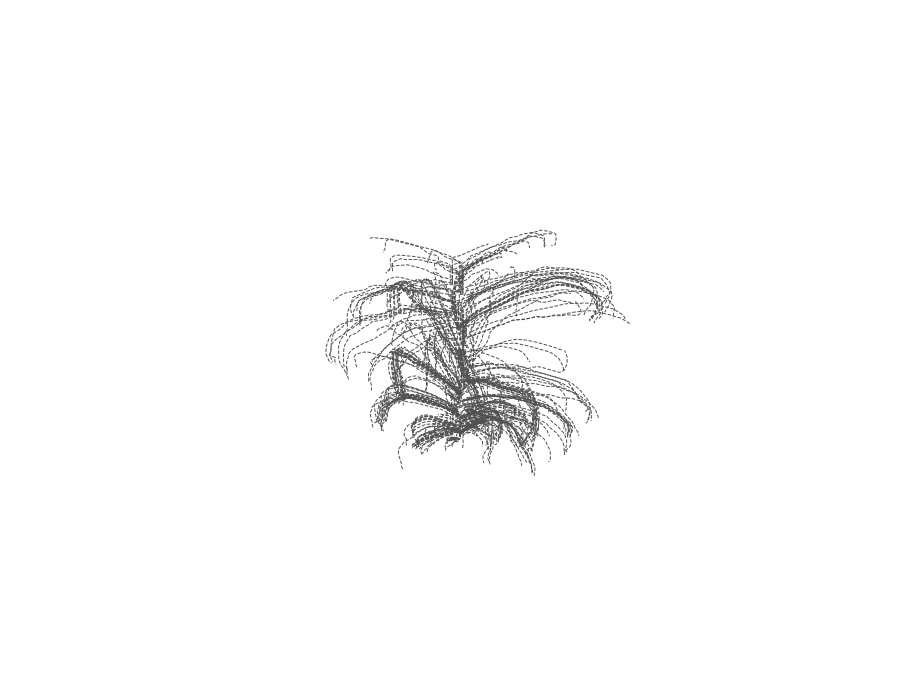

In [5]:
polylines = [pl for seg in phenotrack_segs for pl in seg['polylines_sequence']]
plot3d(polylines, [-1] * len(polylines))

In [6]:
trackedplant = TrackedPlant.load(phenotrack_segs)

# Explain format
## example of a mature leaf and a growing leaf

# 2 - Tracking of mature leaves

# Before

<IPython.core.display.Javascript object>


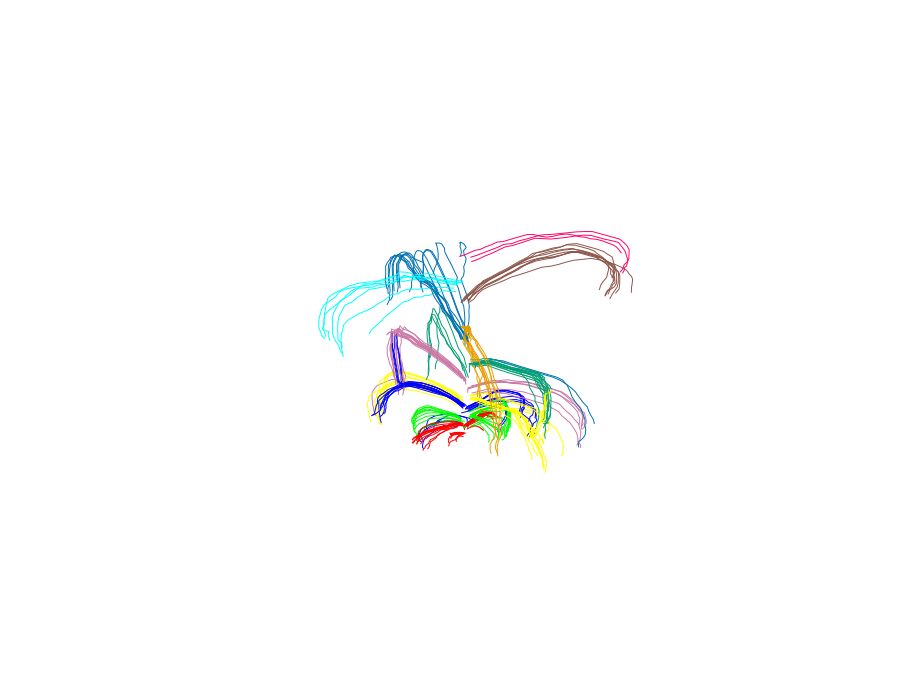

In [7]:
raw_ranks = [r + 1 for s in trackedplant.snapshots for r, l in enumerate(s.leaves) if l.features['mature']]
polylines = [l.polyline for s in trackedplant.snapshots for l in s.leaves if l.features['mature']]
plot3d(polylines, raw_ranks)

# After

In [12]:
trackedplant.mature_leaf_tracking(start=0, # which time step is used to initialize tracking
                                  gap=12, # gap penalty parameter
                                  w_h=0.03, # importance weight for leaf height feature
                                  w_l=0.004, # importance weight for leaf length feature
                                  gap_extremity_factor=0.2, # weight applied to the gap penalty on sequence extremities
                                  align_range=None # maximum distance between two time-steps so that thet can be compared (inf if None)
                                 )

# trackedplant.mature_leaf_tracking(start=-1, gap=2.5, w_h=0.02, w_l=0.004, gap_extremity_factor=0.8, n_previous=5000)

<IPython.core.display.Javascript object>


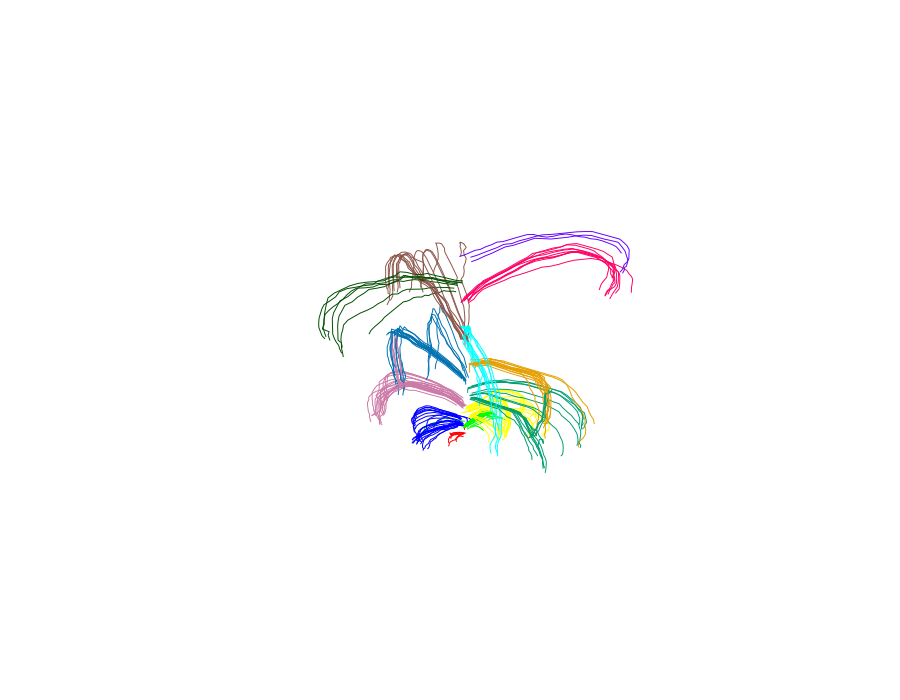

In [13]:
ranks = [r for s in trackedplant.snapshots for l, r in zip(s.leaves, s.leaf_ranks()) if l.features['mature']]
polylines = [l.polyline for s in trackedplant.snapshots for l in s.leaves if l.features['mature']]
plot3d(polylines, ranks)

# 3 - Tracking of growing leaves

In [26]:
trackedplant.growing_leaf_tracking()

<IPython.core.display.Javascript object>


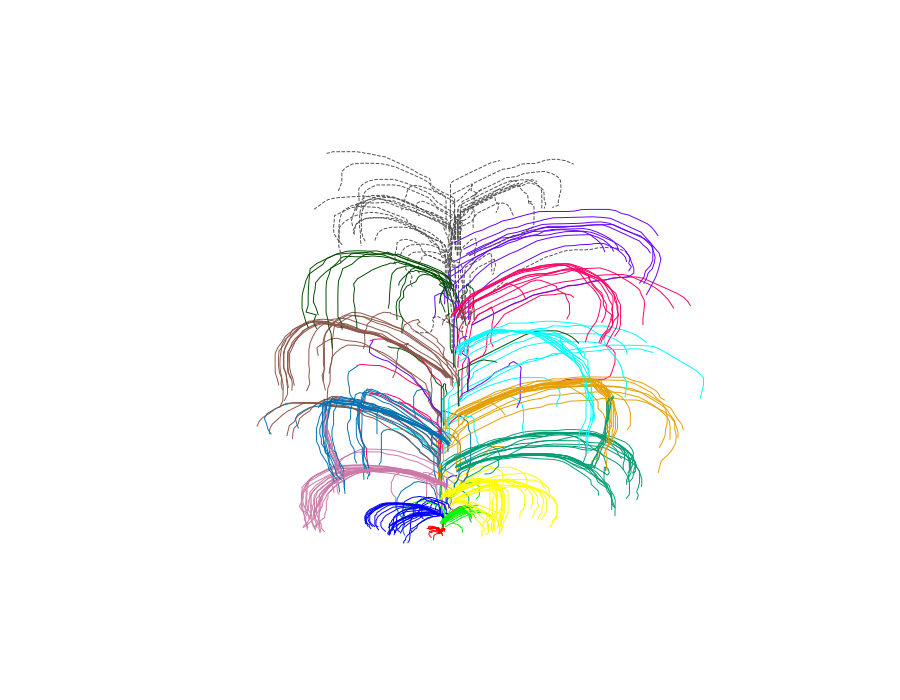

In [27]:
ranks = [r for s in trackedplant.snapshots for l, r in zip(s.leaves, s.leaf_ranks())]
polylines = [l.polyline for s in trackedplant.snapshots for l in s.leaves]
plot3d(polylines, ranks)

# Tell about annotation (put image)